In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Notebooks/

/content/gdrive/MyDrive/Notebooks


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_curve, auc
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os

## Loading saved vec

In [2]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_tr = np.load('saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_tr.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (70000, 51047)
shape of X_test_bow is (30000, 51047)
shape of X_train_tfidf is (70000, 51047)
shape of X_test_tfidf is (30000, 51047)
shape of X_train_avgw2v is (70000, 50)
shape of X_test_avgw2v is (30000, 50)
shape of X_train_tfw2v is (70000, 50)
shape of X_test_tfw2v is (30000, 50)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [3]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()


# Random Forest
# Random Forest On BagOfWords Features

Model with best parameters :
 {'max_depth': 25, 'n_estimators': 120}


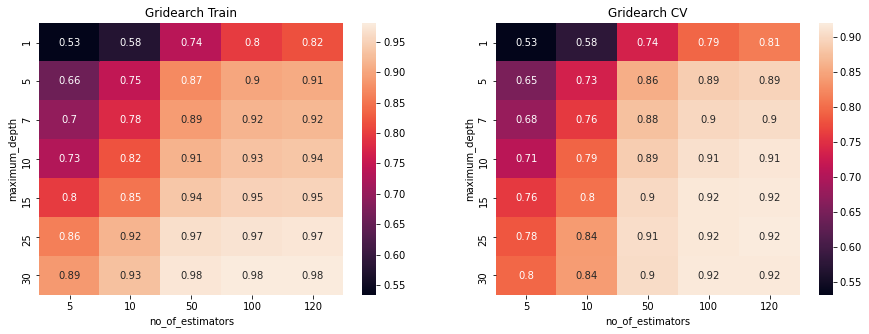

In [4]:
clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_bow,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

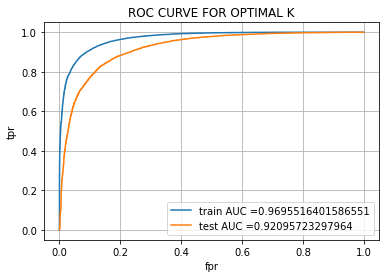

Area under train roc 0.9695516401586551
Area under test roc 0.92095723297964


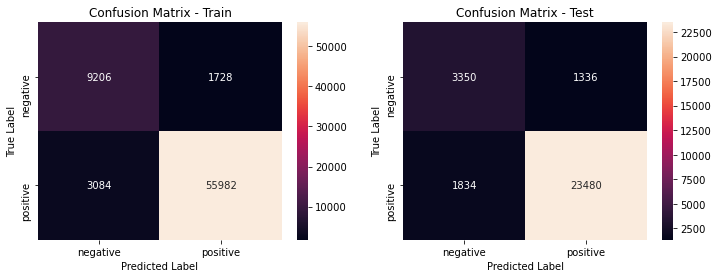

In [5]:
best_est = RandomForestClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_bow,y_tr,X_test_bow,y_test)

Top 20 features are: 
                   coef
not           0.029208
great         0.023124
would         0.016289
disappointed  0.012953
best          0.012239
delicious     0.011137
bad           0.010406
waste         0.010258
perfect       0.010247
worst         0.009060
love          0.008989
money         0.008572
awful         0.007654
horrible      0.007494
highly        0.007456
return        0.006846
product       0.006492
threw         0.006476
thought       0.006324
away          0.006264


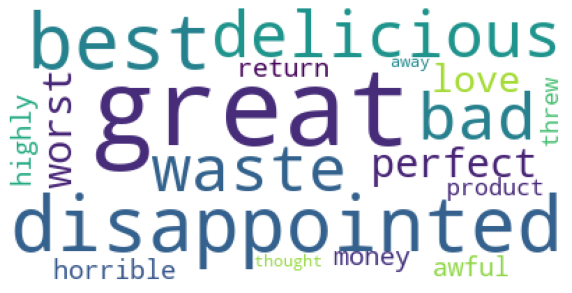

In [6]:
from wordcloud import WordCloud
dataf = best_est.feature_importances_
features = bow_features
dataf = pd.DataFrame(dataf,columns=['coef'],index=features)
top = dataf.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ')
#word cloud representation
wordcloud = WordCloud(background_color='white').generate(sent)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Random Forest On TFIDF Features

Model with best parameters :
 {'max_depth': 30, 'n_estimators': 120}


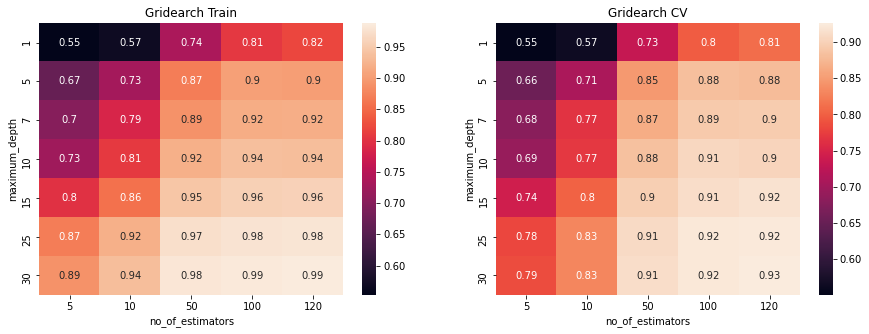

In [7]:
clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_tfidf,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

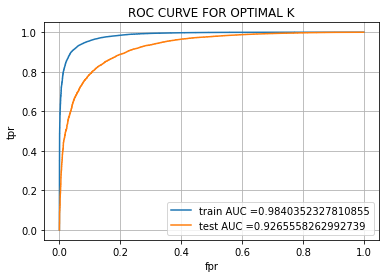

Area under train roc 0.9840352327810855
Area under test roc 0.9265558262992739


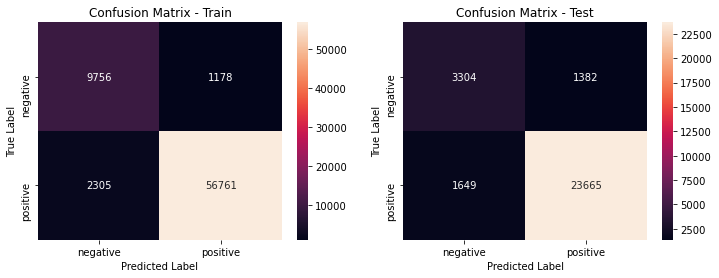

In [8]:
best_est = RandomForestClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfidf,y_tr,X_test_tfidf,y_test)

Top 20 features are: 
                   coef
great         0.032151
not           0.027379
best          0.015102
love          0.012629
delicious     0.011532
perfect       0.010496
money         0.010035
bad           0.009991
good          0.009477
would         0.009416
disappointed  0.008863
worst         0.008438
highly        0.008157
loves         0.007520
excellent     0.007447
waste         0.007411
easy          0.007065
favorite      0.006083
away          0.006070
horrible      0.005974


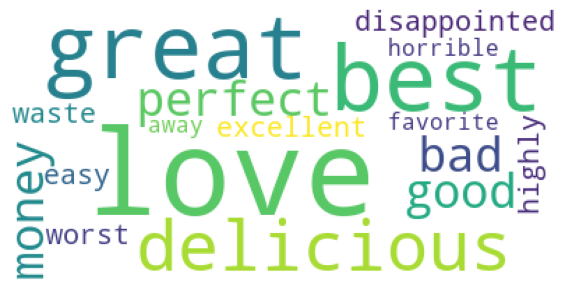

In [9]:
from wordcloud import WordCloud
dataf = best_est.feature_importances_
features = tfidf_features
dataf = pd.DataFrame(dataf,columns=['coef'],index=features)
top = dataf.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ')
#word cloud representation
wordcloud = WordCloud(background_color='white').generate(sent)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Random Forest On AvgWord2Vec

Model with best parameters :
 {'max_depth': 30, 'n_estimators': 120}


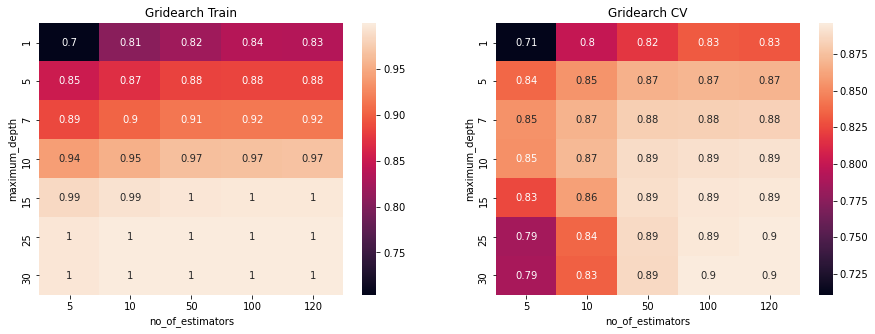

In [10]:
clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_avgw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

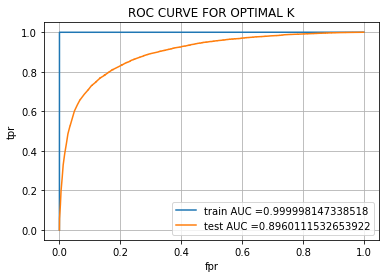

Area under train roc 0.999998147338518
Area under test roc 0.8960111532653922


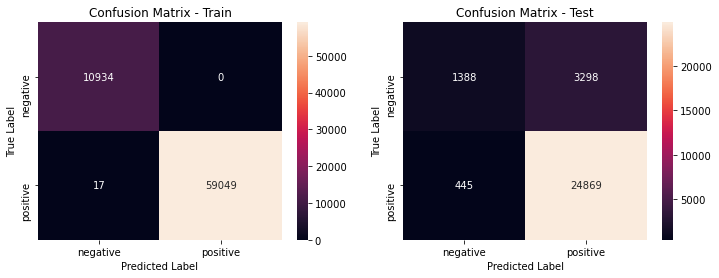

In [11]:
best_est = RandomForestClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_avgw2v,y_tr,X_test_avgw2v,y_test)

# Random Forest TFIDF Word2Vec

Model with best parameters :
 {'max_depth': 25, 'n_estimators': 120}


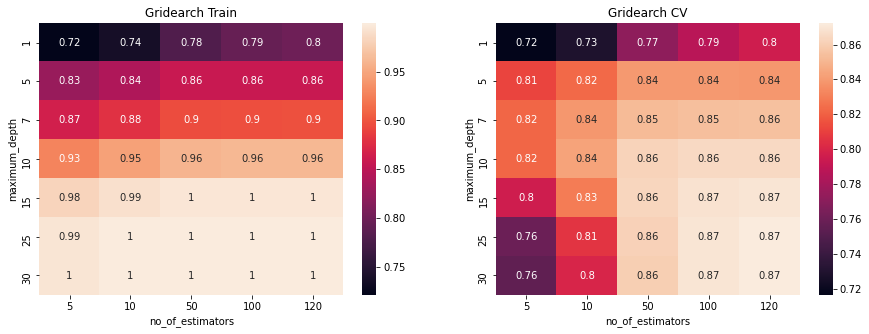

In [12]:
clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_tfw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

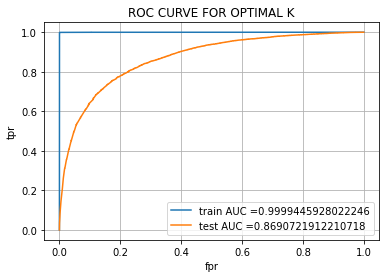

Area under train roc 0.9999445928022246
Area under test roc 0.8690721912210718


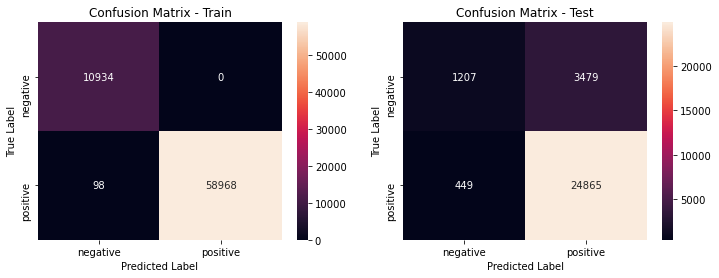

In [13]:
best_est = RandomForestClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_tfw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfw2v,y_tr,X_test_tfw2v,y_test)

# Obseravations and Conclusion

In [14]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","Hyperparam-n_estimator","Hyperparam-max_Depth","Train AUC", "Test AUC"]
z.add_row(["bow","random forest",120,25,0.97273492437445,0.9247230894235081])
z.add_row(["tfidf","random forest",120,25,0.9749652363501523,0.9262508361899533])
z.add_row(["avgw2v","random forest",120,25,0.9999121618913505,0.9019066188004518])
z.add_row(["tfidfw2v","random forest",120,30,0.9999870561042803,0.8766026923217098])
print(z)

+----------+---------------+------------------------+----------------------+--------------------+--------------------+
|  Vector  |   Algorithm   | Hyperparam-n_estimator | Hyperparam-max_Depth |     Train AUC      |      Test AUC      |
+----------+---------------+------------------------+----------------------+--------------------+--------------------+
|   bow    | random forest |          120           |          25          |  0.97273492437445  | 0.9247230894235081 |
|  tfidf   | random forest |          120           |          25          | 0.9749652363501523 | 0.9262508361899533 |
|  avgw2v  | random forest |          120           |          25          | 0.9999121618913505 | 0.9019066188004518 |
| tfidfw2v | random forest |          120           |          30          | 0.9999870561042803 | 0.8766026923217098 |
+----------+---------------+------------------------+----------------------+--------------------+--------------------+
